In [1]:
import numpy as np
from sklearn.decomposition import PCA

#테스트할 데이터
X=np.array([[1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,4,5,6],
            [1,2,1,1,1,1,1,1,1,1,3,4,3,3,3,4,5,6],
            [3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,5,4,6],
            [3,4,3,3,3,1,2,1,1,1,1,1,1,1,1,5,4,5],
            [1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,6,4,5],
            [1,2,1,1,1,3,3,3,2,3,1,1,1,1,1,5,4,5]])

In [3]:
#주성분 분석(3개의 주성분으로 축소)
pca = PCA(n_components = 3)
X2D = pca.fit_transform(X)
X2D

array([[ 3.84432202,  0.20850925,  0.46823094],
       [ 4.09935419, -0.13332384, -0.49268129],
       [-1.70050345, -3.04924012,  0.76869479],
       [-2.21379239, -3.06986255, -0.66041977],
       [-2.102115  ,  3.36337224,  0.55345806],
       [-1.92726537,  2.68054501, -0.63728274]])

In [5]:
#각 주성분의 축에 해당하는 데이터셋의 분산 비율
for i in pca.explained_variance_ratio_:
    print('{:.2f}'.format(i))

0.54
0.42
0.02


In [6]:
#3개의 주성분으로 축소된 자료를 원래의 형태로 복원
#복원 단계에서 정보 손실이 발생할 수 있음
X3D_inv = pca.inverse_transform(X2D)
X3D_inv[0]

array([1.01080967, 1.1237144 , 1.01080967, 1.01080967, 1.01080967,
       1.04652366, 0.87642192, 1.04652366, 1.15635772, 1.04652366,
       2.94266667, 3.3355072 , 2.94266667, 2.94266667, 2.94266667,
       4.16176255, 4.97133333, 6.14683992])

In [7]:
#재구성 오차(reconstruction error) 계산 : 
# 원본 데이터와 압축 후 원복한 데이터 사이의 평균 제곱 거리
1 - pca.explained_variance_ratio_.sum()

0.015189685531841413

> MNIST 데이터

In [8]:
# MNIST : 손글씨 이미지 데이터
# pip install tensorflow
# pip install keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 28x28 => 784로 변환
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

11490434/11490434 [==============================] - 1s 0us/step
[5 0 4 1 9]


In [9]:
#적절한 차원의 수 선택 (분산을 95%로 유지하는 차원의 수 계산)
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [10]:
# 분산비율을 직접 지정하는 방식
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.n_components_) #차원(주성분의 수)
print(np.sum(pca.explained_variance_ratio_)) #분산비율 합계

154
0.9501964


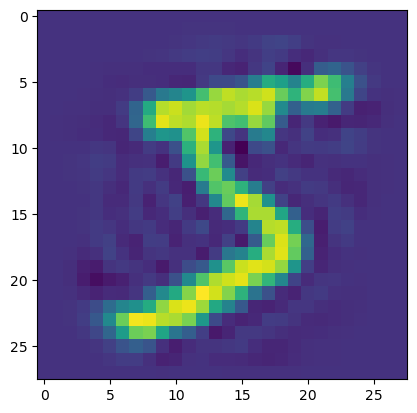

In [11]:
# 154 차원으로 압축
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)

# 784차원으로 복원
X_recovered = pca.inverse_transform(X_reduced)

# 이미지로 시각화
import matplotlib.pyplot as plt
plt.imshow(X_recovered.reshape(60000,28,28)[0])

In [12]:
# 미니배치 방식으로 진행 (점진적 PCA)
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
#미니배치에 해당하는 부분만 사용하므로 메모리가 절약됨
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

....................................................................................................

In [13]:
#일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과 비교
np.allclose(pca.mean_, inc_pca.mean_)
# allclose() 두 배열이 오차범위 내에서 같으면 True, 다르면 False

False

In [14]:
np.mean(pca.mean_), np.mean(inc_pca.mean_)

(0.13066266, 0.1306604774024101)

> 정확도 분석

In [16]:
# PCA를 사용하여 분산이 95%가 되도록 차원 축소
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [15]:
#1. 랜덤 포레스트 모형
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=0)
rnd_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9469

In [17]:
# 1-2. 랜덤 포레스트 모형에 압축된 데이터 입력
rnd_clf2 = RandomForestClassifier(n_estimators=10,
random_state=0)
rnd_clf2.fit(X_train_reduced, y_train)

#검증용 데이터셋으로 평가
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8955

In [18]:
# 2. 로지스틱 회귀분석
# multinomial: 소프트맥스 방식
#시간이 많이 걸림
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(multi_class="multinomial",
                            max_iter=1000, random_state=0)
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9256

In [19]:
# 2-2. 주성분분석으로 축소된 데이터셋으로 학습
log_clf2 = LogisticRegression(multi_class="multinomial",
                            max_iter=1000, random_state=0)
log_clf2.fit(X_train_reduced, y_train)

y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9233